# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

# Environment

## Install modules

In [ ]:
# Install packages for Debugging and Profiling on SageMaker
# 'smdebug' may have error with latest version, so we should use another version.
# Reference: https://pypi.org/project/smdebug/#history
!pip install -U torch torchvision
!pip install -U smdebug
!pip install -U seaborn plotly opencv-python shap imageio bokeh
!pip install -U sagemaker

## Pre-Config

Configure AWS Credential by "environment variable" or edit "~/.aws/credentials" or "aws configure"

In [2]:
# Import any packages that you might need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import boto3
import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs,
    DebuggerHookConfig, CollectionConfig,
    ProfilerConfig, FrameworkProfile, 
)

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import random
import os
import requests

from PIL import Image
from IPython.display import display

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2024-07-17 06:24:06.597 default:131 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
# Initial Settings
role = "arn:aws:iam::008748484958:role/project03-khangtictoc"
region = "us-east-1"

bucket = "project03-khangtictoc"
prefix = "dataset"

# debugger_s3_output = "s3://{}/debugger-output".format(bucket)
# profiler_s3_output = "s3://{}/profiler-output".format(bucket)
local_dataset_path = "./dataset/dogImages"

image_name = "resnet50-training-job"
ecr_name = "public.ecr.aws/q1p8o7w7/resnet50-training-job:latest"

# Create channel for data input's location
train_loc = "s3://project03-khangtictoc/dataset/dogImages/train"
validation_loc = "s3://project03-khangtictoc/dataset/dogImages/valid"
test_loc = "s3://project03-khangtictoc/dataset/dogImages/test"

channels = {
    "training": train_loc,
    "validation": validation_loc,
    "testing": test_loc
}

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

### Download and sync to S3

In [25]:
!aws s3api create-bucket --bucket project03-khangtictoc --region us-east-1


An error occurred (OperationAborted) when calling the CreateBucket operation: A conflicting conditional operation is currently in progress against this resource. Please try again.


In [ ]:
# Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [24]:
#!aws s3api create-bucket --bucket %DEFAULT_S3_BUCKET%

# Window
!aws s3 sync ./dataset/dogImages/train/ s3://{bucket}/dataset/train/
!aws s3 sync ./dataset/dogImages/test/ s3://{bucket}/dataset/test/
!aws s3 sync ./dataset/dogImages/valid/ s3://{bucket}/dataset/valid/

# Linux
#!aws s3 sync ./dataset/train s3://${DEFAULT_S3_BUCKET}/train/
#!aws s3 sync ./dataset/test s3://${DEFAULT_S3_BUCKET}/test/

fatal error: An error occurred (NoSuchBucket) when calling the ListObjectsV2 operation: The specified bucket does not exist
fatal error: An error occurred (NoSuchBucket) when calling the ListObjectsV2 operation: The specified bucket does not exist
fatal error: An error occurred (NoSuchBucket) when calling the ListObjectsV2 operation: The specified bucket does not exist


### Data Loader (Optional)

Use local workspace for investigating data

Define transforming actions

In [2]:
transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [3]:
trainset = datasets.ImageFolder("./dataset/dogImages/train", transform=transforms)
valset = datasets.ImageFolder("./dataset/dogImages/valid", transform=transforms)
testset = datasets.ImageFolder("./dataset/dogImages/test", transform=transforms)

In [4]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)

In [5]:
# Show labels
train_loader.dataset.classes[0:5]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute']

In [6]:
# View some samples and labels
random_img = random.sample(train_loader.dataset.imgs, 5)
random_img

[('./dataset/dogImages/train\\129.Tibetan_mastiff\\Tibetan_mastiff_08184.jpg',
  128),
 ('./dataset/dogImages/train\\025.Black_and_tan_coonhound\\Black_and_tan_coonhound_01781.jpg',
  24),
 ('./dataset/dogImages/train\\091.Japanese_chin\\Japanese_chin_06201.jpg', 90),
 ('./dataset/dogImages/train\\104.Miniature_schnauzer\\Miniature_schnauzer_06887.jpg',
  103),
 ('./dataset/dogImages/train\\094.Komondor\\Komondor_06353.jpg', 93)]

In [7]:
# File extensions
train_loader.dataset.extensions

('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

In [8]:
# Number of labels
print("Number of labels: %d" % len(train_loader.dataset.classes))

# Number of samples
print("Number of samples: %d" % len(train_loader.dataset.imgs))

Number of labels: 133
Number of samples: 6680


# Hyperparameter Tuning

TODO: This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

Note: You will need to use the hpo.py script to perform hyperparameter tuning.

In [4]:
# Declare HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(10, 20)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [6]:
# Create estimators for HPs

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    source_dir="scripts",
    entry_point="hpo.py",
    framework_version="2.2",
    py_version="py310",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [7]:
# Fit HP Tuner
tuner.fit(inputs=channels, wait=True) # Include data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()


2024-05-27 23:35:14 Starting - Found matching resource for reuse
2024-05-27 23:35:14 Downloading - Downloading the training image
2024-05-27 23:35:14 Training - Training image download completed. Training in progress.
2024-05-27 23:35:14 Uploading - Uploading generated training model
2024-05-27 23:35:14 Completed - Resource released due to keep alive period expiry


In [10]:
# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '16',
 'lr': '0.004909233792902113',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-05-27-17-21-30-757"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-028609567580/pytorch-training-2024-05-27-17-21-30-757/source/sourcedir.tar.gz"'}

In [11]:
# Create hyperparameter dict for the best model for later use
best_hyperparameters = {
    "lr": best_estimator.hyperparameters()['lr'],
    "batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')),
    "epochs": int(best_estimator.hyperparameters()['epochs'])
}
best_hyperparameters

{'lr': '0.004909233792902113', 'batch-size': 256, 'epochs': '16'}

# Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

Note: You will need to use the train_model.py script to perform model profiling and debugging.

## Model Training

In [4]:
collection_configs=[
    CollectionConfig(
        name="weights",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="gradients",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="CrossEntopyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

In [5]:
# Configure Debugger

debugger_hook_config = DebuggerHookConfig(
    #s3_output_path=debugger_s3_output,
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    }
)

In [6]:
# Configure Profiler

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10),
    #s3_output_path=profiler_s3_output
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [7]:
# Set up the rules for debugging

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [ ]:
estimator = PyTorch(
    source_dir="scripts",
    entry_point='train_model.py',
    
    base_job_name='dog-breed-pytorch-image-classification',
    role=role,
    instance_count=1,
    instance_type='ml.c4.4xlarge',
    framework_version='1.4.0',
    py_version='py36',
    hyperparameters={'lr': '0.004909233792902113', 'batch-size': 256, 'epochs': '16'},
    
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config
)

estimator.fit({"training": "s3://{}/dataset/dogImages/".format(bucket)}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-breed-pytorch-image-classification-2024-07-17-06-26-05-067


2024-07-17 06:26:06 Starting - Starting the training job...
2024-07-17 06:26:33 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-07-17 06:26:59 Downloading - Downloading input data......
2024-07-17 06:28:03 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-17 06:28:19,440 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-17 06:28:19,443 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-07-17 06:28:19,456 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-07-17 06:28:19,458 sagemaker_pytorch_container.training INFO     Invokin

## Plot a debugging output.

In [185]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-07-16 17:34:31.470 default:143 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-008748484958/dog-breed-pytorch-image-classification-2024-07-16-17-18-44-610/debug-output


> Tensors are data collections of updated parameters from the backward and forward pass of each training iteration. SageMaker Debugger collects the output tensors to analyze the state of a training job
Link: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configure-hook.html

In [186]:
print(trial.tensor_names())

['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.1.relu_input_2', 'layer3.2.relu_input_0', 'layer3.2.relu_input_1', 'layer3.2.relu_input_2', 'layer3.3.relu_input_0', 'layer3.3.relu_input_1', 'layer3.3.relu_input_2', 'layer3.4.relu_input_0', 

In [187]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

1
1


In [152]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [153]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


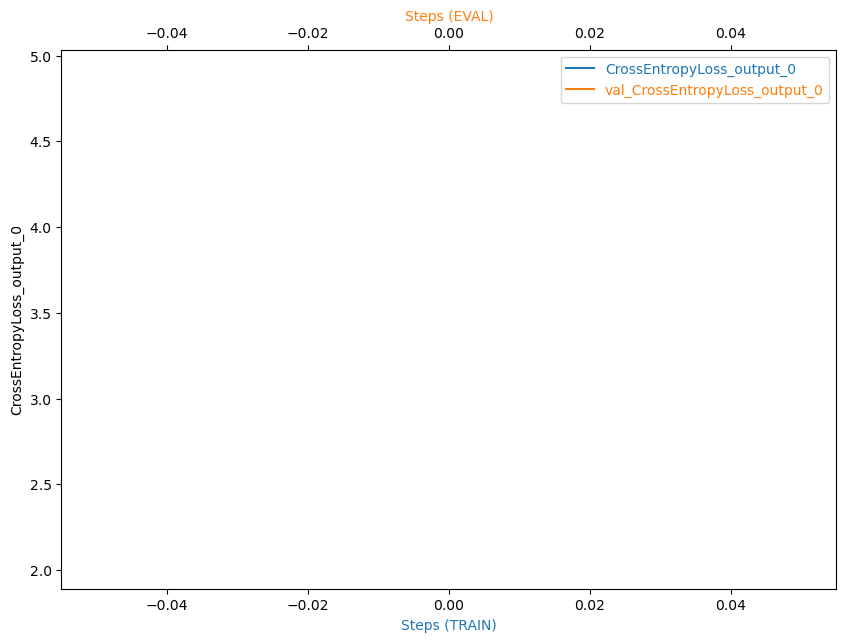

In [154]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Display the profiler output

In [9]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print("Rule output S3 path: ", rule_output_path)
print("Save profile report to local ...")
!aws s3 cp {rule_output_path} ./ --recursive

Rule output S3 path:  s3://sagemaker-us-east-1-008748484958/dog-breed-pytorch-image-classification-2024-07-17-06-26-05-067/rule-output
Save profile report to local ...
download: s3://sagemaker-us-east-1-008748484958/dog-breed-pytorch-image-classification-2024-07-17-06-26-05-067/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-008748484958/dog-breed-pytorch-image-classification-2024-07-17-06-26-05-067/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-008748484958/dog-breed-pytorch-image-classification-2024-07-17-06-26-05-067/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker

In [40]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [41]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

Locate where model are saved in S3. Make sure model are stored after training job is completed

In [33]:
model_location = estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-008748484958/dog-pytorch-2024-07-16-07-34-28-395/output/model.tar.gz


- Defined the predicting class: determine the serialize and deserialize method
- Create `inference.py` script to perform predicting for a incoming data request API. Reference: https://course19.fast.ai/deployment_amzn_sagemaker.html

In [34]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [35]:
pytorch_model = PyTorchModel(
    source_dir="scripts",
    model_data=model_location, 
    role=role, 
    entry_point='inference.py',
    py_version='py3',
    framework_version='1.4',
    predictor_cls=ImagePredictor)

In [37]:
predictor = pytorch_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large',
    endpoint_name="dog-pytorch-endpoint-multi-instance"
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-008748484958/dog-pytorch-2024-07-16-07-34-28-395/output/model.tar.gz), script artifact (scripts), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-008748484958/pytorch-inference-2024-07-16-07-48-48-576/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-07-16-07-48-56-863
INFO:sagemaker:Creating endpoint-config with name dog-pytorch-endpoint-multi-instance
INFO:sagemaker:Creating endpoint with name dog-pytorch-endpoint-multi-instance


------!

Create a temporary folder for predicting images. Set "Bucket Policy" to allow get the image URL via HTTPS, allow public internet access.

In [89]:
request_dict={ "url": "https://project03-khangtictoc.s3.amazonaws.com/predict_samples/Yorkshire_terrier_08326.jpg" }
img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

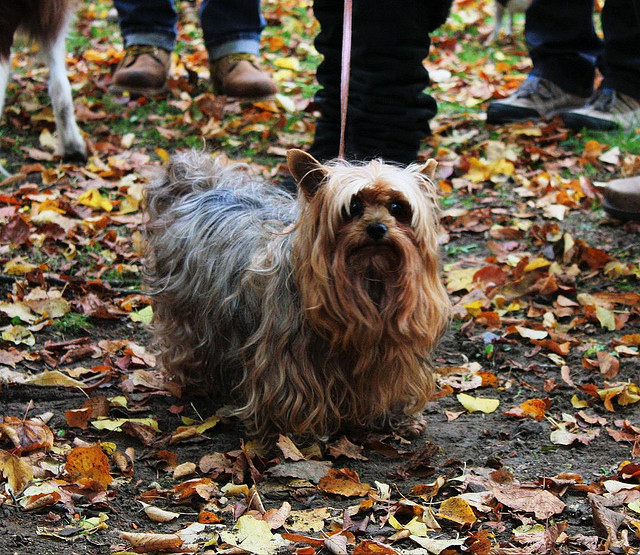

In [90]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [87]:
response = predictor.predict(img_bytes, initial_args = {"ContentType": "image/jpeg"})

View list of probabilities of each label

In [91]:
response

[[0.36231982707977295,
  0.1448449194431305,
  0.24116048216819763,
  0.13514846563339233,
  0.5010687112808228,
  0.40839117765426636,
  0.26153305172920227,
  0.2956863343715668,
  0.06633390486240387,
  0.14172904193401337,
  0.30134373903274536,
  0.4351769983768463,
  0.15237554907798767,
  0.37265411019325256,
  0.44083264470100403,
  0.28616419434547424,
  0.3621886372566223,
  0.10619916021823883,
  0.06447309255599976,
  0.09136340022087097,
  0.08056192100048065,
  0.297518789768219,
  0.4526185393333435,
  0.34222611784935,
  0.12663669884204865,
  0.06246766075491905,
  0.33058035373687744,
  -0.006951590068638325,
  0.4274057149887085,
  0.037196166813373566,
  -0.04509031027555466,
  0.34374165534973145,
  0.20517116785049438,
  0.3553081750869751,
  -0.11402806639671326,
  0.11390897631645203,
  0.2864871919155121,
  0.4174201786518097,
  0.3254551887512207,
  0.3439050018787384,
  0.23520544171333313,
  0.05144355446100235,
  -0.09284857660531998,
  0.1999446302652359,


Retrieve the max value to get the predicted label

In [92]:
np.argmax(response, 1)

array([4])

In [93]:
# IMPORTANT) Shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: dog-pytorch-endpoint-multi-instance
INFO:sagemaker:Deleting endpoint with name: dog-pytorch-endpoint-multi-instance


# Package your Model

Set up remote registry

In [ ]:
ecr_client = boto3.client("ecr")
ecr_response = ecr_client.create_repository(repositoryName="only-test")
ecr_response

In [ ]:
# Create ECR Repository if not exists
!aws ecr-public create-repository --repository-name {image_name}

{
    "repository": {
        "repositoryArn": "arn:aws:ecr-public::008748484958:repository/resnet50-training-job",
        "registryId": "008748484958",
        "repositoryName": "resnet50-training-job",
        "repositoryUri": "public.ecr.aws/q1p8o7w7/resnet50-training-job",
        "createdAt": "2024-05-24T15:42:19.395000+07:00"
    },
    "catalogData": {}
}


In [5]:
# Authenticate AWS ECR
# Push command on Console
#!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com
!aws ecr-public get-login-password --region us-east-1 | docker login --username AWS --password-stdin public.ecr.aws/q1p8o7w7

Login Succeeded


WARNING! Your password will be stored unencrypted in C:\Users\tranh\.docker\config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



Upload image to registry

In [ ]:
# Package training model to Docker Image
!docker build -t {image_name} .

In [12]:
# Re-tag images to remote ECR registry
!docker tag {image_name}:latest public.ecr.aws/q1p8o7w7/{image_name}:latest
# Push image to remote AWS ECR
!docker push public.ecr.aws/q1p8o7w7/{image_name}:latest

The push refers to repository [public.ecr.aws/q1p8o7w7/resnet50-training-job]
bbe00fe64b55: Preparing
9501e9fcc404: Preparing
1c4281c1b467: Preparing
8f3dd49b5d19: Preparing
555315c92a50: Preparing
3be02ac4f30b: Preparing
4a36b0c85768: Preparing
6addedefeb30: Preparing
f21b8e6382b2: Preparing
3be02ac4f30b: Waiting
4a36b0c85768: Waiting
6addedefeb30: Waiting
f21b8e6382b2: Waiting
a1c8c36e3146: Preparing
a1c8c36e3146: Waiting
88c6b56a015e: Preparing
d4c2f7022d7b: Preparing
88c6b56a015e: Waiting
d4c2f7022d7b: Waiting
37d54eb19c68: Preparing
e7c49386baa5: Preparing
37d54eb19c68: Waiting
e7c49386baa5: Waiting
6723bb391f86: Preparing
2b77c1837fdd: Preparing
c308ea0f2bb6: Preparing
91e1df25c605: Preparing
72b51d6d1d55: Preparing
90dfc325730b: Preparing
ef7f8b990cf9: Preparing
454df595b059: Preparing
078266e4cb4c: Preparing
fb99a34a5b47: Preparing
6723bb391f86: Waiting
454df595b059: Waiting
2b77c1837fdd: Waiting
91e1df25c605: Waiting
72b51d6d1d55: Waiting
90dfc325730b: Waiting
c308ea0f2bb6: Wa